*Francisco Javier Sáez Maldonado*

Consideramos la cadena de Markov:

![Markov Chain](mc.png)

En la que asumimos que cada estado hay una flecha hasta sí mismo que hace que las probabilidades en la salida sean $1$ y $p=0.3$.

Únicamente con esto, podemos definir la matriz de transición:

$$
P=\begin{pmatrix}
1-p & p & 0 & 0 & 0 & 0 \\
0 & 1-p &  p/2 & 0 & p/2 & 0 \\
1/4 & 0 & 1/4 & 1/4 & 1/4 & 0\\
q & 0 & 0 & 0.9-q & 0.1 & 0 \\
0 & 0 & 0 & 0 & 1/2 & 1/2 \\
0 & 0 & 0 & 1/4 & 1/2 & 1/4 
\end{pmatrix}
$$

Con esto, queda resuelto el primer apartado de la entrega. Continuamos con el resto. Importamos primero las librerías necesarias para realizar los ejercicios.

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from tqdm import tqdm
np.random.seed(123)

Definimos ahora dos matrices, que contendrán las dos cadenas de Markov que vamos a considerar.

In [2]:
p = 0.3
q = 0.0
P1 = np.array([
    [ 1.0-p, p, 0.0, 0.0, 0.0, 0.0],                  
    [ 0.0,1.0-p, p/2.0, 0.0 , p/2.0, 0.0],
    [ 0.25, 0.0, 0.25, 0.25, 0.25, 0.0],
    [ q, 0.0, 0.0, 0.9-q, 0.1, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 0.5, 0.5],
    [ 0.0, 0.0, 0.0, 0.25, 0.5, 0.25]])
q = 0.1
P2 = np.array([
    [ 1.0-p, p, 0.0, 0.0, 0.0, 0.0],                  
    [ 0.0,1.0-p, p/2.0, 0.0 , p/2.0, 0.0],
    [ 0.25, 0.0, 0.25, 0.25, 0.25, 0.0],
    [ q, 0.0, 0.0, 0.9-q, 0.1, 0.0],
    [ 0.0, 0.0, 0.0, 0.0, 0.5, 0.5],
    [ 0.0, 0.0, 0.0, 0.25, 0.5, 0.25]])

Podemos definir ahora una clase `MarkovChain`. Esta clase estará inicializada únicamente con la matriz de transición que determina a nuestra cadena de Markov. Realizamos una serie de métodos para la clase, que nos realizarán esencialmente los ejercicios que tenemos que hacer. Entre ellos están:

- `_next`, que nos devuelve un paso empírico en una simulación de un experimento usando una cadena de Markov.
- `_simulation`, que nos realiza la simulación completa (utilizando la función anterior)
- `_simulation_position`, que hace una simulación hasta encontrar un estado y devuelve la posición en la que se encuentra, o $-1$.
- `empirical_h`, que nos calcula la probabilidad probabilidad de pasar por un estado, usando $n$ experimentos diferentes
- `empirical_k`, que nos calcula la media de tiempo en alcanzar un estado usando $n$ experimentos
- `theoretical_h`, `theoretical_k`, que calculan las cantidades anteriores pero de forma teórica usando la matriz $P$ y resolviendo el sistema de ecuaciones teórico (necesario para la cuarta pregunta).
- `probability_H`, que nos calcula la probabilidad teórica de $P[H_m^A = t]$.
- `probability_empirical_H`, que nos calcula la probabilidad empírica $P[H_m^A = t]$ realizando simulaciones.


In [3]:
class MarkovChain:

    """
    Class that encapsulates the behaviour of a Markov chain, determined by its transition matrix.
    This class makes simulations using different methods (with and without stops) and computes both 
    first hitting time and average hitting time between any two given states, using the class methods.
    """
    def __init__(self, P):
        """
        Inicialization of the Markov chain
        - P: transition matrix
        """
        self.P = P
        self.n = len(P[0])
        
        
    def _next(self,curr_m):
        """
        Simulate an empirical step using an uniform distribution.
        Idea: divide [0,1] in n_states parts, where the measure of each
        part is its probability and use cumulative_sum(probabilities) >= generated_number
        - curr_m: current state
        """

        # Generate from the Uniform(0,1)
        gen = random.rand()
   
        # Return index of the first state that matches the condition
        return int(np.where(np.cumsum(self.P[curr_m]) >= gen)[0][0])
    
    def _simulation(self, m_ini, t):
        """
        Generate complete simulation of t time steps, beginning in the state m_ini
        - m_ini: initial state
        - t: time steps that will be done
        """
        
        # Initialize states
        states = [0]*t
        # Compute first jump
        states[0] = self._next(m_ini)
        # Loop to compute jumps
        for i in range(1,t):
            states[i] = self._next(states[i-1])
    
        return states
    
    def _simulation_position(self,m_ini,m_end,t):
        """
        Generate a simulation that will stop in t time steps or right after finding the state m_end
        - m_ini: initial state
        - m_end: final state
        - t: maximum time steps
        """
        # Change the variable name
        curr = m_ini
        # Return if it is in the first step
        if curr == m_end:
            return 0
        # Loop over the possible time steps
        for i in range(1,t):
            following = self._next(curr)
            # Stop condition
            if following == m_end:
                return i
            curr = following
        
        return -1
        
    
    def empirical_h(self,m_ini, m_end, t, n):
        """
        Compute the empirical hitting h_{m_ini}^{m_end} time, using n experiments of t time steps
        - m_ini: initial state
        - m_end: final state
        - t: time steps
        - n: number of experiments
        """
        # Trivial case
        if m_ini == m_end:
            return 1.0
        # Find if the searched state is in the simulation
        hit = [1 if m_end in self._simulation(m_ini, t) else 0 for _ in range(n)]
        # Obtain all hits
        hits = np.sum(hit)
        # Return probability
        return hits/n
    
    def empirical_k(self, m_ini, m_end, t, n):
        """
        Compute the average time k_{m_ini}^{m_end} of hitting m_end from m_ini, using n experiments of t time steps
        - m_ini: initial state
        - m_end: final state
        - t: time steps
        - n: number of experiments
        """
        
        if m_ini == m_end:
            return 0.0
        
        # Get the simulations stopping if we find our position
        simulations = [ self._simulation_position(m_ini,m_end,t) for _ in range(n)]
        
        # Return average or infinity
        return np.Infinity if -1 in simulations else np.mean(simulations)
        
    def theoretical_h(self, m_end):
        """
        Compute the theoretical hitting probability of the state m_end from any of the states
        It uses the Matrix form of the Linear Equations system Ax = b
        - m_end: final state
        """
        # Compute the matrix A 
        A = self.P - np.diag(np.ones(self.n))
        # Compute b
        b = np.zeros(self.n)
        # Force conditions to match the theorem conditions
        b[m_end] = 1
        A[m_end] = b
        
        # Solve using nnls
        return nnls(A, b)[0]
        
        
    def theoretical_k(self, m_end, m_ini = None):
        """
        Compute the theoretical average hitting time of the state m_end from any of the states
        It uses the Matrix form of the Linear Equations system Ax = b
        - m_end: final state
        - m_ini (optional). Used for infinite time corrections
        """
        
        # Check infinite time problem
        if m_ini != None:
            theo_h = self.theoretical_h(m_end)[m_ini]
            if theo_h < 1:
                return [np.Infinity]*self.n
                
        # Compute A and b
        A = np.diag(np.ones(self.n)) - self.P
        b = np.ones(self.n)
        # Match the conditions of the theorem
        b[m_end] = 0
        A[m_end] = np.logical_not(b)
        
        # Solve using nnls
        return nnls(A, b)[0]
        
    def probability_H(self, m_ini, m_end, max_t ):
        """
        Computes theoretical probability of being in the state m_end from m_ini in exactly t movements, for
        a range of ts: (0,max_t). It is computed using a recurrence explained in this notebook.
        - m_ini: initial state
        - m_end: final state
        - max_t: maximum of the different time steps taken.
        """
    
        # Recurrence indexes, all but m_end
        idx = list(np.arange(self.n))
        idx.remove(m_end)
        
        # Result
        g = np.zeros(max_t + 1)
        
        # Initial iteration, P[i,j]
        f = self.P[idx,m_end]
        
        # Compute first 2 iterations separatedly since they are not computed the same way
        g[0] = 0
        g[1] = f[m_ini]
        # Rest of iterations
        for t in range(2,max_t + 1):
            f = [f @ self.P[i,idx] for i in idx]
            g[t] = f[m_ini]
            
        return g
    
    def probability_empirical_H(self,m_ini,m_end,max_t,n):
        """
        Computes empirical probability of being in the state m_end from m_ini in exactly t movements, for
        a range of ts: (0,max_t). n experiments are performed to achieve this.
        - m_ini: initial state
        - m_end: final state
        - max_t: maximum of the different time steps taken.
        - n: number of experiments.
        """
        
        g = np.zeros(max_t+1)
        
        g[0] = 0
        for t in tqdm(range(1,max_t)):
            # Get the simulations
            simulation_positions = np.array([ self._simulation_position(m_ini,m_end, t) for _ in range(n)])
            
            # Get where we find it in the right position.
            # t-1 is dued to how _simulation_position works
            times = np.where(simulation_positions == t-1)[0]
            
            # Return probability
            g[t-1] = len(times)/n
            
        return g
        
        
        


Con esta clase, podemos declarar nuestros objetos Cadena de Markov del siguiente modo (declaramos uno para cada una de las matrices de transición). Vamos a usar $t = 1000$ instantes de tiempo para evaluar todos los experimentos y, en el caso de tener que promediar la salida de varios experimentos, usaremos $n = 1000$ experimentos.

In [4]:
n = 1000
t = 1000
mc = MarkovChain(P1)
mc1 = MarkovChain(P2)


**Ejercicio 2.-** Simular el funcionamiento de la cadena y hacer una estimación de conjunto de $h_0^2$ y $h_0^5$ para $q = 0.1$ y $q = 0$.

Ahora, podemos simular el funcionamiento de la cadena usando `empirical_h` sobre cada una de las cadenas para estimar $h_0^2$ y $h_0^5$.

In [5]:
print("Empirical probabilities h")
print("Con q = 0")
print("\t h02 = {}".format(mc.empirical_h(0 , 2 , n, t)))
print("\t h05 = {}".format(mc.empirical_h(0 , 5 , n, t)))
print("Con q = 0.1")
print("\t h02 = {}".format(mc1.empirical_h(0 , 2 , n, t)))
print("\t h05 = {}".format(mc1.empirical_h(0 , 5 , n, t)))

Empirical probabilities h
Con q = 0
	 h02 = 0.53
	 h05 = 1.0
Con q = 0.1
	 h02 = 1.0
	 h05 = 1.0


Podemos ver que :

- Cuando usamos $q = 0$, la probabilidad llegar de $0$ a $5$ ($h_0^5$), es $1$ , mientras que la de llegar del estado $0$ al $2$ ($h_0^2$) es de aproximadamente $\frac{1}{2}$. Esto ocurre porque en el primer caso, tenemos una clase cerrada $\{3,4,5\}$ y por tanto, si ocurre la secuencia: $0\to 1 \to 4$, ya no hay forma de volver al segundo estado.

- Al aumentar $q = 0.1$, la probabilidad de llegar del estado $0$ al $2$ pasa automáticamente a ser 1. Esto tiene sentido, Al *activar* la vuelta desde el nodo $3$ al nodo $0$, ya no tenemos esta clase cerrada y podemos volver al estado inicial.

**Ejercicio 3.-** Simular el funcionamiento de la cadena y hacer una estimación de conjunto de $k_0^2$ y $k_4^2$ para $q = 0.1$ y $q = 0$.

In [6]:
print("Empirical means k")
print("Con q = 0")
print("\t k02 = {}".format(mc.empirical_k(0 , 2 , n, t)))
print("\t k42 = {}".format(mc.empirical_k(4 , 2 , n, t)))
print("Con q = 0.1")
print("\t k02 = {}".format(mc1.empirical_k(0 , 2 , n, t)))
print("\t k42 = {}".format(mc1.empirical_k(4 , 2 , n, t)))

Empirical means k
Con q = 0
	 k02 = inf
	 k42 = inf
Con q = 0.1
	 k02 = 41.457
	 k42 = 77.131


Obtenemos las siguientes conclusiones:

- Con $q = 0$, tenemos un comportamiento parecido al que ocurre en el caso del *first hitting time*. Empezando desde el estado $4$, que está en una clase cerrada, nunca se puede salir de esa clase. Empezando desde el $0$, al tener una clase cerrada, en algunos casos nunca se llegará al estado $2$, por lo que tendremos tiempos infinitos y la media será de nuevo infinito. 

- Repitiendo de nuevo el razonamiento, al eliminar la clase cerrada, siempre podremos llegar a todos los estados en cualquier momento, por lo que la media deja de ser infinito.

**Ejercicio 4.-** Usar el sistema de ecuaciones lineares oportuno para determinar los valores teóricos correspondientes
a las cantidades estimadas y comparar con los valores determinados por medio de la simulación

Planteamos primero la base teórica. Sabemos que, el vector de las *hitting probabilities* $h_m^n$ de un conjunto $A\subseteq M$, es decir $h^A = [h^A_m| m \in M]'$ es la solución minimal no negativa del sistema:
$$
\begin{cases}
h_m^A = 1 & m \in A\\
h_m^A= \sum_{n\in M} P_{m,n} h_n^A & m \notin A
\end{cases}
$$

Es por ello que, lo que debemos expresar nuestro sistema como un sistema lineal de la forma $Ax = b$. Dada la matriz de transición $P$ y el vector $h = [h_0^m,\dots,h_n^m]'$. Podemos tomar como punto de partida el sistema $Ph = h$. Podemos despejarlo matricialmente para obtener el sistema $(P - I_n)h = 0$. Este sistema no está cumpliendo la primera restricción del teorema. Para conseguirlo, debemos

- Sustituir la fila $m-$ésima por un vector $v = [0,\dots,1,\dots,0]$, donde el $1$ está en la posición $m$.
- Sustituir el $0$ matricial por el vector $v^T$.

Con estas condiciones, podemos tratar de buscar la solución minimal no negativa del sistema. Para ello, tenemos la función `nnls` de `scipy`, que nos resuelve el problema
$$
\operatorname{arg}\min_x || Ax-b||_2\quad \quad x \geq 0,
$$
que es justo la solución que nos interesa.

En nuestro caso, la función `mc.theoretical_h` nos da la probabilidad teórica de llegar al estado `m_end` empezando desde cada uno de los estados iniciales y  en un número de pasos de tiempo $t$.

In [7]:
print("Theoretical probabilities h")
print("Con q = 0")
print("\t h02 = {}".format(mc.theoretical_h(2)[0]))
print("\t h05 = {}".format(mc.theoretical_h(5)[0]))
print("Con q = 0.1")
print("\t h02 = {}".format(mc1.theoretical_h(2)[0]))
print("\t h05 = {}".format(mc1.theoretical_h(5)[0]))

Theoretical probabilities h
Con q = 0
	 h02 = 0.5
	 h05 = 0.9999999999999986
Con q = 0.1
	 h02 = 1.0000000000000007
	 h05 = 0.9999999999999981


Vemos como obtenemos, salvo errores de redondeo, los mismos valores que se obtenían de forma empírica, por lo que podemos decir que nuestros resultados anteriores son correctos.

Del mismo modo, sabemos que el vector de los *mean hitting times* $k_m^n$ de un conjunto $A \subseteq M$, es decir, $k^A = [k_m^A | m \in M]'$ es la solución minimal no negativa del sistema:
$$
\begin{cases}
k_m^A = 0 & m \in A\\
k_m^A= 1 + \sum_{n\in M} P_{m,n} k_n^A & m \notin A
\end{cases}
$$

Cambiamos un poco el razonamiento, aunque es parecido al caso anterior. Podemos escribir la expresión de abajo como $k = 1 + Pk \Rightarrow 1 = (I - P)$. Con esto, hacemos el mismo razonamiento que en el caso anterior, salvo que ahora nuestro vector $v$ será $v = [1,\dots,0,\dots,1]$, que tiene un $0$ en la posición $m$.

Además, hay que tener en cuenta que si el valor medio es infinito, no podemos obtener esta solución mediante el sistema, pero sabemos que esto es equivalente a tener un $h_m^n < 1$, por lo que primero calculamos este valor y si ocurre que es menor que uno, devolveremos infinito.

In [8]:
print("Theoretical means k")
print("Con q = 0")
print("\t k02 = {}".format(mc.theoretical_k(2,m_ini = 0)[0]))
print("\t k42 = {}".format(mc.theoretical_k(2,m_ini = 4)[4]))
print("Con q = 0.1")
print("\t k02 = {}".format(mc1.theoretical_k(2, m_ini = 0)[0]))
print("\t k42 = {}".format(mc1.theoretical_k(2, m_ini = 4)[4]))

Theoretical means k
Con q = 0
	 k02 = inf
	 k42 = inf
Con q = 0.1
	 k02 = 43.33333333333339
	 k42 = 73.33333333333343


De nuevo, obtenemos el resultado que habíamos obtenido empíricamente, por lo que podemos de nuevo reafirmarnos en que nuestro resultado anterior era correcto.

**Ejercicio 5.-** En el caso $q =0.1$, dibujar el gráfico de 
$$
g(t) = \mathbb P[H_0^{\{4\}} = t]
$$

Se nos pide dibujar la función que nos da para cada instante de tiempo $t$, la probabilidad de que ese instante de tiempo $t$ sea el *first hitting time* del estado $4$ si hemos partido del $0$. Queremos el gráfico teórico. Podemos encontrar este valor de forma recurrente, en los siguientes pasos:

1. Consideramos $k$ el estado final.
2. Para llegar a $k$ desde otro estado $j\neq k$, el *first hitting time* del estado $j$ debe ser $t-1$. Queremos calcular entonces $\mathbb P[H_i^j = t-1]$. Debemos sumar en todos los posibles estados anteriores.
3. De nuevo, para llegar hasta $j$ desde otro estado $z$, repetimos el razonamiento para obtener que tenemos que calcular $\mathbb P[H_i^z = t-2]$. Debemos de nuevo sumar en todos los posibles estados anteriores.

Si llamamos $f_{ij}^{(t)} = \mathbb P[H_i^j = t]$ y sabiendo que $f_{ij}^{(1)} = P_{ij}$, en general, podemos hacer la recurrencia:
$$
f_{ij}^{(t)} = \sum_{k \neq j} P_{ik}f_{kj}^{(t-1)}
$$

In [9]:
def plot_probability_H(markov_chain, m_ini, m_end, max_t,n):
    gs = markov_chain.probability_H(m_ini,m_end,max_t)
    gs_empirical = markov_chain.probability_empirical_H(m_ini,m_end,max_t,n)
    
    #fig, axs = plt.subplots(1, 3)
    
    #axs[0,0]
    
    plt.plot(np.arange(0,max_t+1),gs,"--",lw = 3,label = "Theoretical")
    plt.plot(np.arange(0,max_t+1),gs_empirical,lw = 2,color = "red",alpha = 0.8,label = "Empirical")
    plt.ylabel("g(t)")
    plt.xlabel("t")
    plt.legend()
    
    print("Maximum = {}".format(max(gs)))
    print("The maximum is in t = {}".format(np.argmax(gs)))
    plt.show()
    

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:45<00:00,  2.16it/s]

Maximum = 0.08629312499999998
The maximum is in t = 5


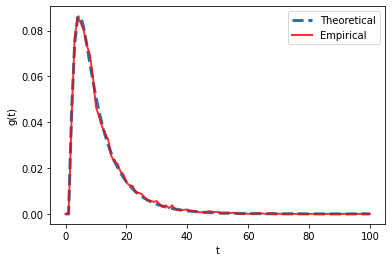

In [10]:
plot_probability_H(mc,0,4,100,10**4)

Podemos comprobar como la función $g(t)$ empírica, cuando aumentamos el número de veces que repetimos el experimento a un número suficientemente grande (en este caso, hemos usado $10^4$), aproxima de forma suficientemente buena a la función $g$ teórica que hemos hallado usando la recurrencia.

Obtenemos que el número de instantes de tiempo en el que es más probable que tras ese número de instantes hayamos llegado desde el estado $0$ al estado $4$ es $5$, aunque con una probabilidad relativamente baja.

**Ejercicio 5.-** Afirmo que $H_0^4 < H_0^5$ siempre. ¿ Es cierto ? ¿ Por qué sí ?

Podemos mirar el grafo de la cadena de Markov para ver que la única forma de llegar al estado $5$ es habiendo pasado antes por el estado $4$. Además, vemos que del estado $4$ sólo puede llegarse al $5$, por lo que si $H_0^5 = t$, entonces obligatoriamente $H_0^4 \leq t-1$ siempre, por lo que tenemos que $H_0^4 < H_0^5$ siempre.